In [ ]:
import torch
import json
import os
import matplotlib.pyplot as plt
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    # BitsAndBytesConfig, 
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling,
)
from datasets import load_dataset, concatenate_datasets
from transformers.trainer_callback import TrainerCallback
from peft import LoraConfig, get_peft_model, PeftModel
from tqdm import tqdm
import warnings
from torch.utils.data import DataLoader
from torch.optim import AdamW

In [ ]:
# Suppress warnings
warnings.filterwarnings("ignore")

# --- 1. Configuration ---
MODEL_NAME = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
HOTPOT_DATASET_NAME = "hotpot_qa"
HOTPOT_DATASET_CONFIG = "distractor"
MATH_DATASET_NAME = "qwedsacf/competition_math"
RESULTS_DIR = "./drive/MyDrive/"

JOINT_ADAPTER_PATH = os.path.join(RESULTS_DIR, "joint_adapter_llama_fp32")

TASK_B_ADAPTER_PATH = os.path.join(RESULTS_DIR, "math_adapter_llama_fp32")


# --- VRAM-Saving Config ---
MAX_SEQ_LENGTH = 2048
PER_DEVICE_BS = 64
GRAD_ACC_STEPS = 1 

# --- Experiment Config ---
N_TRAIN_EXAMPLES = 4000
N_VAL_EXAMPLES = 400
JOINT_EPOCHS = 2
TASK_A_EPOCHS = 2
TASK_B_EPOCHS = 1 

In [ ]:
# --- 2. Utility Functions (Data Formatting - Llama Chat Style) ---
def format_hotpot_qa(example):
    """Formats HotpotQA data into a Llama-chat-style prompt."""
    context = " ".join(["".join(s) for s in example["context"]["sentences"]])
    question = example["question"]
    answer = example["answer"]

    text = (
        f"<s>[INST] You are a helpful assistant. Use the following context to "
        f"answer the question. Context: {context}\n\nQuestion: {question} [/INST] "
        f"Answer: {answer}</s>"
    )
    return text

def format_math(example):
    """Formats MATH data into a Llama-chat-style prompt."""
    problem = example["problem"]
    solution = example["solution"]

    text = (
        f"<s>[INST] You are a math expert. Solve the following math problem. "
        f"Show your work.\nProblem: {problem} [/INST] "
        f"Solution: {solution}</s>"
    )
    return text

def filter_by_length(example, tokenizer, formatter):
    text = formatter(example)
    tokenized = tokenizer(text, max_length=MAX_SEQ_LENGTH + 1, truncation=False, padding=False)
    return len(tokenized['input_ids']) <= MAX_SEQ_LENGTH

def preprocess(example, tokenizer, formatter):
    text = formatter(example)
    tokenized = tokenizer(
        text,
        max_length=MAX_SEQ_LENGTH,
        truncation=True,
        padding="max_length",
    )
    labels = tokenized["input_ids"].copy()
    inst_token_id = tokenizer.convert_tokens_to_ids("]")

    split_point = -1
    for i in range(len(tokenized["input_ids"]) - 1, -1, -1):
        if tokenized["input_ids"][i] == inst_token_id:
            split_point = i + 1
            break

    if split_point == -1:
        return {}

    for i in range(split_point):
        labels[i] = -100

    tokenized["labels"] = labels
    return tokenized

In [ ]:

def get_model_and_tokenizer_base():
    model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        dtype=torch.bfloat16, 
        device_map="auto",
        trust_remote_code=True,
    )
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = "right"

    model.gradient_checkpointing_enable()

    return model, tokenizer

def get_lora_config():
    return LoraConfig(
        r=8,
        lora_alpha=16,
        target_modules=[
            "q_proj",
            "k_proj",
            "v_proj",
            "o_proj",
        ],
        lora_dropout=0.05,
        bias="none",
        task_type="CAUSAL_LM",
    )
def manual_evaluate(model, dataloader, device):
    model.eval() 
    total_loss = 0
    total_steps = 0
    with torch.no_grad(): 
        for batch in tqdm(dataloader, desc="Evaluating", leave=False):
            batch = {k: v.to(device) for k, v in batch.items() if k in ["input_ids", "attention_mask", "labels"]}

            outputs = model(**batch)
            loss = outputs.loss

            total_loss += loss.item()
            total_steps += 1

    model.train() 
    return total_loss / total_steps

In [ ]:
# --- 4. Main Experiment Logic ---
def main():
    if not os.path.exists(RESULTS_DIR):
        os.makedirs(RESULTS_DIR)

    print(f"--- Loading Base Model & Tokenizer ---")
    base_model, tokenizer = get_model_and_tokenizer_base()

    data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

    # --- Load and Process Datasets ---
    print(f"\n--- Loading and Preprocessing Datasets (This may take a while) ---")

    # Task A: HotpotQA
    raw_hotpot = load_dataset(HOTPOT_DATASET_NAME, HOTPOT_DATASET_CONFIG)
    hotpot_train = raw_hotpot["train"].shuffle(seed=42).select(range(N_TRAIN_EXAMPLES))
    hotpot_val = raw_hotpot["validation"].shuffle(seed=42).select(range(N_VAL_EXAMPLES))

    print(f"Tokenizing and filtering HotpotQA...")
    hotpot_train_tokenized = hotpot_train.filter(
        lambda x: filter_by_length(x, tokenizer, format_hotpot_qa),
        batched=False,
    ).map(
        lambda x: preprocess(x, tokenizer, format_hotpot_qa),
        batched=False,
    ).filter(lambda example: len(example) > 0)

    hotpot_val_tokenized = hotpot_val.filter(
        lambda x: filter_by_length(x, tokenizer, format_hotpot_qa),
        batched=False,
    ).map(
        lambda x: preprocess(x, tokenizer, format_hotpot_qa),
        batched=False,
    ).filter(lambda example: len(example) > 0)

    print(f"HotpotQA: {len(hotpot_train_tokenized)} train, {len(hotpot_val_tokenized)} val (after filtering)")

    # Task B: MATH
    raw_math = load_dataset(MATH_DATASET_NAME)
    total_math_samples_needed = N_TRAIN_EXAMPLES + N_VAL_EXAMPLES
    math_subset = raw_math["train"].shuffle(seed=42).select(range(total_math_samples_needed))
    val_size_fraction = N_VAL_EXAMPLES / total_math_samples_needed
    math_splits = math_subset.train_test_split(test_size=val_size_fraction, seed=42)
    math_train = math_splits["train"]
    math_val = math_splits["test"]

    print(f"Tokenizing and filtering MATH...")
    math_train_tokenized = math_train.filter(
        lambda x: filter_by_length(x, tokenizer, format_math),
        batched=False,
    ).map(
        lambda x: preprocess(x, tokenizer, format_math),
        batched=False,
    ).filter(lambda example: len(example) > 0)

    math_val_tokenized = math_val.filter(
        lambda x: filter_by_length(x, tokenizer, format_math),
        batched=False,
    ).map(
        lambda x: preprocess(x, tokenizer, format_math),
        batched=False,
    ).filter(lambda example: len(example) > 0)

    print(f"MATH: {len(math_train_tokenized)} train, {len(math_val_tokenized)} val (after filtering)")

    # --- Experiment 2: Sequential Training (CF) [MATH -> HotpotQA] ---
    print(f"\n--- Starting Experiment 2: Sequential Training (CF) [MATH -> HotpotQA] ---")

    # --- Phase 1: Train on MATH (or load from checkpoint) ---
    if os.path.exists(os.path.join(TASK_B_ADAPTER_PATH, "adapter_model.safetensors")):
        print(f"--- Found existing Task B (MATH) adapter. Loading from {TASK_B_ADAPTER_PATH} ---")
        seq_model = PeftModel.from_pretrained(base_model, TASK_B_ADAPTER_PATH, is_trainable=True)
        print("Adapter loaded successfully.")

    else:
        print(f"--- No adapter found. Starting Phase 1: Training on Task B (MATH) ---")
        lora_config = get_lora_config()
        seq_model = get_peft_model(base_model, lora_config)
        seq_model.print_trainable_parameters()

        seq_args_b = TrainingArguments(
            output_dir=os.path.join(RESULTS_DIR, "seq_training_B_temp"),
            per_device_train_batch_size=PER_DEVICE_BS,
            gradient_accumulation_steps=GRAD_ACC_STEPS,
            num_train_epochs=TASK_B_EPOCHS,
            learning_rate=2e-4,
            bf16=True, 
            logging_steps=10,
            save_strategy="no",
            report_to="none",
            gradient_checkpointing=True,
        )

        seq_trainer_b = Trainer(
            model=seq_model,
            args=seq_args_b,
            train_dataset=math_train_tokenized,
            eval_dataset=math_val_tokenized,
            data_collator=data_collator,
        )

        seq_trainer_b.train()

        print(f"--- Phase 1 (MATH) training complete. Saving adapter to {TASK_B_ADAPTER_PATH} ---")
        seq_model.save_pretrained(TASK_B_ADAPTER_PATH)
        print("Adapter saved.")

        del seq_trainer_b
        torch.cuda.empty_cache()

     # --- Evaluate the "Task B Expert" model (whether trained or loaded) ---
    print("\n--- Evaluating Model after Phase 1 (Task B Expert) ---")
    eval_args = TrainingArguments(
        output_dir=os.path.join(RESULTS_DIR, "eval_temp"),
        per_device_eval_batch_size=PER_DEVICE_BS,
        bf16=True, 
        report_to="none",
        gradient_checkpointing=True,
    )


    eval_trainer = Trainer(
        model=seq_model,
        args=eval_args,
        data_collator=data_collator,
    )

    eval_hotpot_phase1 = eval_trainer.evaluate(eval_dataset=hotpot_val_tokenized)
    print(f"  > Task B Expert - HotpotQA Val Loss: {eval_hotpot_phase1['eval_loss']:.4f}")
    eval_math_phase1 = eval_trainer.evaluate(eval_dataset=math_val_tokenized)
    print(f"  > Task B Expert - MATH Val Loss: {eval_math_phase1['eval_loss']:.4f}")
    del eval_trainer, eval_args
    torch.cuda.empty_cache()
    # --- Phase 2: Train on HotpotQA (Forgetting MATH happens here) ---
    print(f"\n  --- Phase 2: Training on Task A (HotpotQA) ---")
    history = {"steps": [], "hotpot_loss": [], "math_loss": []}
    # Custom Trainer to log forgetting
    class ForgettingTrackerCallback(TrainerCallback):
      def __init__(self, hotpot_val, math_val, history_log, start_metrics):
          super().__init__()
          self.hotpot_eval_dataset = hotpot_val
          self.math_eval_dataset = math_val
          self.history = history_log
          self.trainer = None
          self.is_evaluating = False
          # ----------------
          self.history["steps"].append(0)
          self.history["hotpot_loss"].append(start_metrics['hotpot_loss'])
          self.history["math_loss"].append(start_metrics['math_loss'])
          print("Initializing ForgettingTrackerCallback with starting metrics.")
      def set_trainer(self, trainer):
          self.trainer = trainer
          print("Trainer reference set in callback.")

      def on_log(self, args, state, control, **kwargs):
          if self.is_evaluating:
              return
          self.is_evaluating = True
          if not self.trainer:
              print("WARNING: Trainer reference not set in callback, skipping eval.")
              self.is_evaluating = False 
              return
          print(f"\n--- Custom Eval at Step {state.global_step} ---")
          print("Evaluating on Task A (HotpotQA)...")
          hotpot_metrics = self.trainer.evaluate(eval_dataset=self.hotpot_eval_dataset)
          hotpot_loss = hotpot_metrics['eval_loss']
          print(f"  > Step {state.global_step} - HotpotQA Val Loss: {hotpot_loss:.4f} (LEARNING?)")
          print("Evaluating on Task B (MATH)...")
          math_metrics = self.trainer.evaluate(eval_dataset=self.math_eval_dataset)
          math_loss = math_metrics['eval_loss']
          print(f"  > Step {state.global_step} - MATH Val Loss: {math_loss:.4f} (FORGETTING?)")
          self.history["steps"].append(state.global_step)
          self.history["hotpot_loss"].append(hotpot_loss)
          self.history["math_loss"].append(math_loss)
          self.is_evaluating = False
          self.trainer.model.train()


    seq_args_a = TrainingArguments(
        output_dir=os.path.join(RESULTS_DIR, "seq_training_A"),
        per_device_train_batch_size=PER_DEVICE_BS,
        gradient_accumulation_steps=GRAD_ACC_STEPS,
        num_train_epochs=TASK_A_EPOCHS,
        learning_rate=2e-4,
        logging_steps=10,
        save_strategy="no",
        bf16=True,
        report_to=[],         
        # disable_tqdm=True,  
        gradient_checkpointing=True,
    )
    seq_model.enable_input_require_grads()
    tracker_callback = ForgettingTrackerCallback(
        hotpot_val=hotpot_val_tokenized,
        math_val=math_val_tokenized,
        history_log=history,
        start_metrics={
            'hotpot_loss': eval_hotpot_phase1['eval_loss'],
            'math_loss': eval_math_phase1['eval_loss'],
        }
    )
    seq_trainer_a = Trainer(
        model=seq_model,
        args=seq_args_a,
        train_dataset=hotpot_train_tokenized,
        eval_dataset=hotpot_val_tokenized,
        data_collator=data_collator,
        callbacks=[tracker_callback] 
    )
    tracker_callback.set_trainer(seq_trainer_a)
    seq_trainer_a.train()

    # --- 5. Plot Results ---
    print("\n--- Saving History Data and Generating Plot ---")

    # --- history data 2 JSON ---
    history_filename = os.path.join(RESULTS_DIR, "forgetting_history_MATH_to_HotpotQA_fp32.json")
    try:
        with open(history_filename, 'w') as f:
            json.dump(history, f, indent=4)
        print(f"History data saved to {history_filename}")
    except Exception as e:
        print(f"Error saving history to JSON: {e}")
    # --- [END] ---

    plt.figure(figsize=(12, 6))
    plt.plot(history["steps"], history["hotpot_loss"], 'o-', label="Task A (HotpotQA) Loss", color="blue")
    plt.plot(history["steps"], history["math_loss"], 'o-', label="Task B (MATH) Loss", color="red")

    plt.title(f"Catastrophic Forgetting: MATH -> HotpotQA (Model: {MODEL_NAME} FP32 LoRA)")
    plt.xlabel(f"Training Steps on Task A (HotpotQA) (Total Epochs: {TASK_A_EPOCHS})")
    plt.ylabel("Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.yscale('log')
    plt.tight_layout()

    plot_filename = os.path.join(RESULTS_DIR, "sequential_forgetting_curve_MATH_to_HotpotQA_fp32.png")
    plt.savefig(plot_filename)
    print(f"Plot saved to {plot_filename}")

    try:
        from google.colab import files
        plt.show()
    except ImportError:
        print("Not in Colab, plot saved to file.")

INFO: Running on GPU. VRAM: 85.17 GB
--- Loading Base Model & Tokenizer ---


config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]


--- Loading and Preprocessing Datasets (This may take a while) ---


README.md: 0.00B [00:00, ?B/s]

distractor/train-00000-of-00002.parquet:   0%|          | 0.00/166M [00:00<?, ?B/s]

distractor/train-00001-of-00002.parquet:   0%|          | 0.00/166M [00:00<?, ?B/s]

distractor/validation-00000-of-00001.par(…):   0%|          | 0.00/27.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/90447 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/7405 [00:00<?, ? examples/s]

Tokenizing and filtering HotpotQA...


Filter:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3686 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3686 [00:00<?, ? examples/s]

Filter:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/367 [00:00<?, ? examples/s]

Filter:   0%|          | 0/367 [00:00<?, ? examples/s]

HotpotQA: 3686 train, 367 val (after filtering)


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001-7320a6f3aba8eb(…):   0%|          | 0.00/4.85M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/12500 [00:00<?, ? examples/s]

Tokenizing and filtering MATH...


Filter:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3994 [00:00<?, ? examples/s]

Filter:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/399 [00:00<?, ? examples/s]

Filter:   0%|          | 0/399 [00:00<?, ? examples/s]

MATH: 3994 train, 399 val (after filtering)

--- Starting Experiment 2: Sequential Training (CF) [MATH -> HotpotQA] ---
--- Found existing Task B (MATH) adapter. Loading from ./drive/MyDrive/math_adapter_llama_fp32 ---


The model is already on multiple devices. Skipping the move to device specified in `args`.


Adapter loaded successfully.

--- Evaluating Model after Phase 1 (Task B Expert) ---


  > Task B Expert - HotpotQA Val Loss: 1.8908


The model is already on multiple devices. Skipping the move to device specified in `args`.


  > Task B Expert - MATH Val Loss: 1.0678

  --- Phase 2: Training on Task A (HotpotQA) ---
Initializing ForgettingTrackerCallback with starting metrics.
Trainer reference set in callback.


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss,Validation Loss
10,1.795100,1.138058
20,1.771200,1.213078
30,1.751400,1.264371
40,1.732600,1.290161
50,1.737300,1.298706
60,1.739300,1.298977
70,1.733900,1.301736
80,1.725300,1.306578
90,1.715600,1.308413
100,1.727600,1.309453



--- Custom Eval at Step 10 ---
Evaluating on Task A (HotpotQA)...
  > Step 10 - HotpotQA Val Loss: 1.7872 (LEARNING?)
Evaluating on Task B (MATH)...
  > Step 10 - MATH Val Loss: 1.1381 (FORGETTING?)

--- Custom Eval at Step 20 ---
Evaluating on Task A (HotpotQA)...
  > Step 20 - HotpotQA Val Loss: 1.7667 (LEARNING?)
Evaluating on Task B (MATH)...
  > Step 20 - MATH Val Loss: 1.2131 (FORGETTING?)

--- Custom Eval at Step 30 ---
Evaluating on Task A (HotpotQA)...
  > Step 30 - HotpotQA Val Loss: 1.7580 (LEARNING?)
Evaluating on Task B (MATH)...
  > Step 30 - MATH Val Loss: 1.2644 (FORGETTING?)

--- Custom Eval at Step 40 ---
Evaluating on Task A (HotpotQA)...
  > Step 40 - HotpotQA Val Loss: 1.7524 (LEARNING?)
Evaluating on Task B (MATH)...
  > Step 40 - MATH Val Loss: 1.2902 (FORGETTING?)

--- Custom Eval at Step 50 ---
Evaluating on Task A (HotpotQA)...
  > Step 50 - HotpotQA Val Loss: 1.7486 (LEARNING?)
Evaluating on Task B (MATH)...
  > Step 50 - MATH Val Loss: 1.2987 (FORGETTING?)


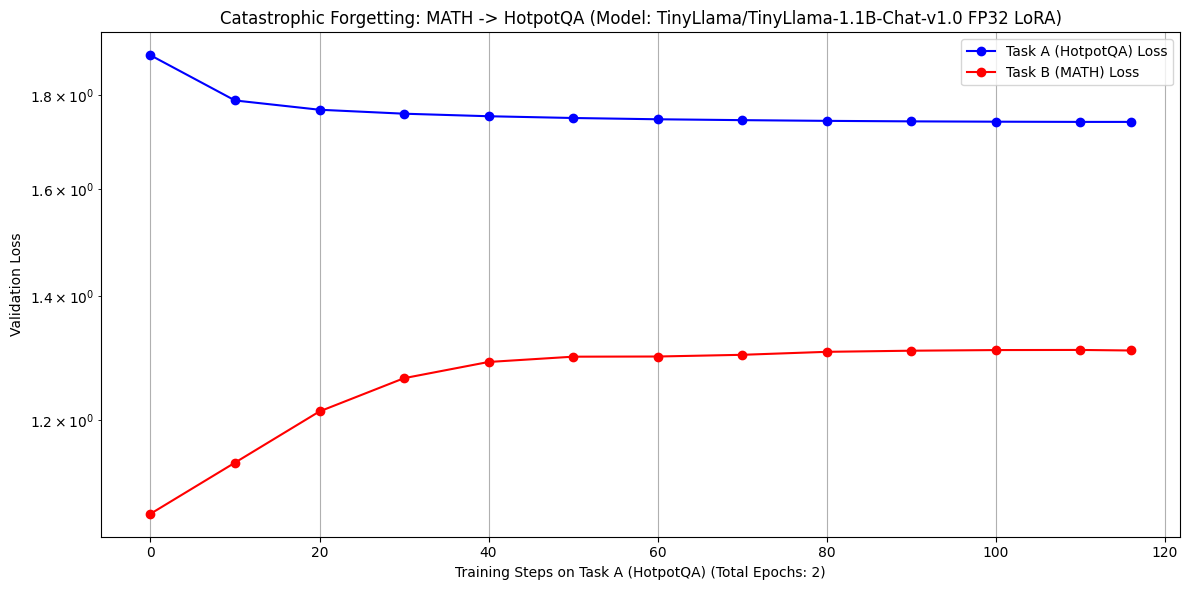

In [ ]:
if __name__ == "__main__":
    if not torch.cuda.is_available():
        print("ERROR: This experiment requires a GPU. Check Colab runtime type.")
    else:
        print(f"INFO: Running on GPU. VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
        if torch.cuda.get_device_properties(0).total_memory / 1e9 < 11:
            print("WARNING: VRAM is less than 11GB. You may hit OOM errors. Try lowering MAX_SEQ_LENGTH.")
    main()